In [4]:
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx


In [5]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    VACCINATED = 1
    INFECTED_S = 2
    INFECTED_V = 3
    RECOVERED_S = 4
    RECOVERED_V = 5

In [6]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, SV,unique_id, model):
        super().__init__(unique_id, model)
        self.SV = SV
        if self.SV == "S":
            self.state = State.SUSCEPTIBLE
        else:
            self.state = State.VACCINATED 


    def move(self):
        """Move the agent"""

        possible_steps = [
            node
            for node in self.model.grid.get_neighbors(self.pos, include_center=False)
            if self.model.grid.is_cell_empty(node)
        ]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)
    
    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED_S: 
            recovery_rate_Is = 1 - np.exp(-self.model.gamma)
            
            recovered = np.random.choice([0,1], p=[recovery_rate_Is,1-recovery_rate_Is])
            if recovered == 0:
                self.state = State.RECOVERED_S

                
        if self.state == State.INFECTED_V: 
            recovery_rate_Iv = 1 - np.exp(-self.model.gamma * self.model.delta)
            
            recovered = np.random.choice([0,1], p=[recovery_rate_Iv,1-recovery_rate_Iv])
            if recovered == 0:
                self.state = State.RECOVERED_V




    def contact(self):
        """Find close contacts and infect"""
        
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_vaccinated_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if ((agent.state is State.SUSCEPTIBLE) or (agent.state is State.VACCINATED))
        ]
        
        for other in susceptible_vaccinated_neighbors:        
            if self.random.random() > self.model.beta:
                continue

                #If Contatct Wtih Other agent
            if self.state is State.INFECTED_S and other.state is State.SUSCEPTIBLE:
                rate = 1 - np.exp(-self.model.beta)
                decision = np.random.choice([0,1], p=[rate,1-rate])

                if decision == 0:
                    other.state = State.INFECTED_S


            if self.state is State.INFECTED_S and other.state is State.VACCINATED:   
                r = self.model.beta * (1-self.model.eta)-self.model.beta * (1-self.model.eta)*self.model.effectiveness
                rate = 1 - np.exp(-r)
                decision = np.random.choice([0,1], p=[rate,1-rate])

                if decision == 0:
                    other.state = State.INFECTED_V


            if self.state is State.INFECTED_V and other.state is State.SUSCEPTIBLE:
                rate = 1- np.exp(-self.model.beta)
                decision = np.random.choice([0,1], p=[rate,1-rate])

                if decision == 0:
                    other.state = State.INFECTED_S


            if self.state is State.INFECTED_S and other.state is State.VACCINATED:
                r  = self.model.beta * (1-self.model.eta)-self.model.beta * (1-self.model.eta)*self.model.effectiveness
                rate = 1- np.exp(-r)
                decision = np.random.choice([0,1], p=[rate,1-rate])

                if decision == 0:
                    other.state = State.INFECTED_V

    def step(self):
        self.status()
        self.move()
        self.contact()
        
    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)

In [7]:
class SIRVModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10,num_vaccination = 5,avg_node_deg=10,
                beta = 0.833,gamma = 1/3, delta = 3,eta = 0.3, effectiveness = 0.5):
        
        self.num_agents = N
        self.num_vaccination = num_vaccination
        
        
        #parameters
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.eta = eta
        self.effectiveness = effectiveness
        

        
        self.connection_prob = avg_node_deg/self.num_agents
        self.G = nx.erdos_renyi_graph(n=self.num_agents, p=self.connection_prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)

        
        self.running = True
        
        
        
        # Agent Creation 
        for i, node in enumerate(self.G.nodes()):
            if i < self.num_vaccination:
                a = MyAgent("V",i+1, self)
            else:
                a = MyAgent("S", i+1, self)
            self.schedule.add(a)
            self.grid.place_agent(a,node)
            

            # If want to make some agent initially infected but here we take initially 
            if a.state == State.VACCINATED:
                infected = np.random.choice([0,1], p=[0.005,0.995])
                
                if infected == 0:
                    a.state = State.INFECTED_V

                
            elif a.state == State.SUSCEPTIBLE:
                infected = np.random.choice([0,1], p=[0.015,0.985])
                if infected == 0:
                    a.state = State.INFECTED_S

                
        # Collecting States of agent
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini}, 
            agent_reporters={"State": "state"})
            
        
 
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [8]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Vaccinated','Infected_S','Infected_V','Recovered_S', 'Recovered_V']
    X.columns = labels[:len(X.columns)]
    return X
    

In [16]:
population=10000
steps = 30
st=time.time()
model = SIRVModel(N=population, num_vaccination=population*0.5, effectiveness = 0.9)
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))

13.45641803741455
      Susceptible  Vaccinated  Infected_S  Infected_V  Recovered_S  \
Step                                                                 
0            4932        4977          68          23            0   
1            4549        4918         383          54           68   
2            3434        4655        1288         230          278   
3            1775        4108        2399         486          826   
4             770        3427        2586         637         1644   
5             398        2864        2156         599         2446   
6             258        2518        1681         445         3061   
7             206        2295        1218         313         3576   
8             187        2180         857         176         3956   
9             179        2111         585         116         4236   
10            173        2069         431          62         4396   
11            171        2036         310          49         4519   
12

In [30]:
def prep(model):
    X = get_column_data(model)
    if "Infected_V" in X and 'Vaccinated' in X:
        X["Vaccinated"] = X["Vaccinated"] +   X["Infected_V"]
    if 'Infected_S' in X and 'Infected_V' in X:
        X["Infected"] = X['Infected_S'] + X['Infected_V']
    if 'Recovered_S' in X and 'Recovered_V' in X:
        X["Recoverd"] = X["Recovered_S"] + X["Recovered_V"]
    if ('Infected_S' in X) and ('Infected_V' in X) and ('Recovered_V' in X) and ('Recovered_S' in X):
        X.drop(columns=['Infected_S','Infected_V','Recovered_V','Recovered_S'], axis=1,inplace=True)
    X.to_csv("MergeColumn.csv")
    return X
    

X = prep(model)
f,ax= plt.subplots(1,1,figsize=(10,6))
X.plot(ax=ax,lw=3,alpha=0.8,xlim=[0,steps],ylim=[0,population])
plt.plot()
title = f"eta = {i}"
plt.title(title)





# plt.savefig('SIRV1.jpg',dpi=500)
# X.head()

SyntaxError: f-string: empty expression not allowed (3668901171.py, line 19)

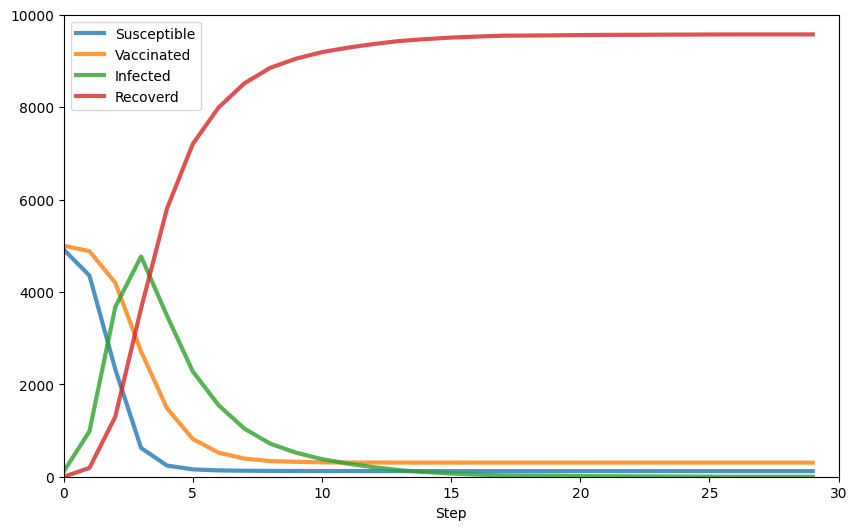

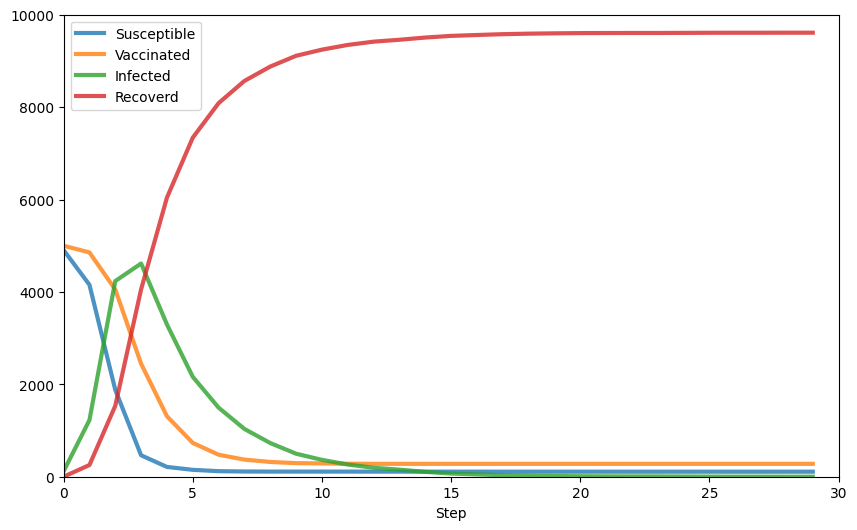

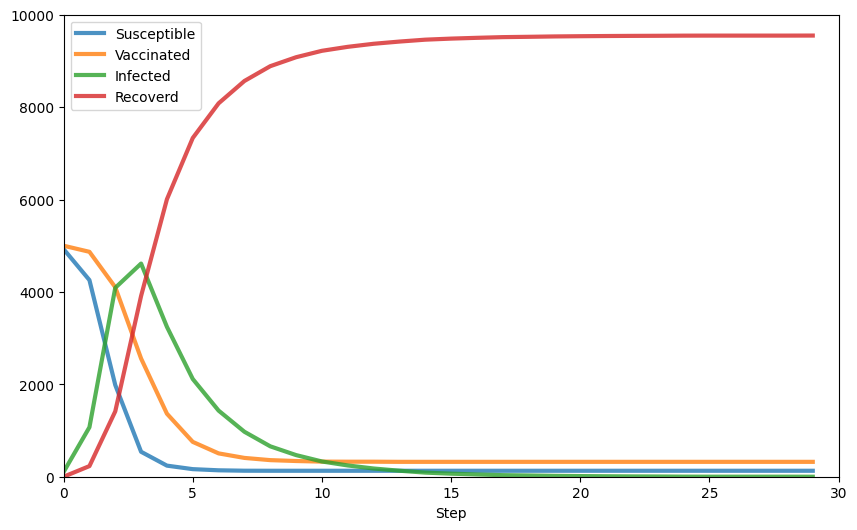

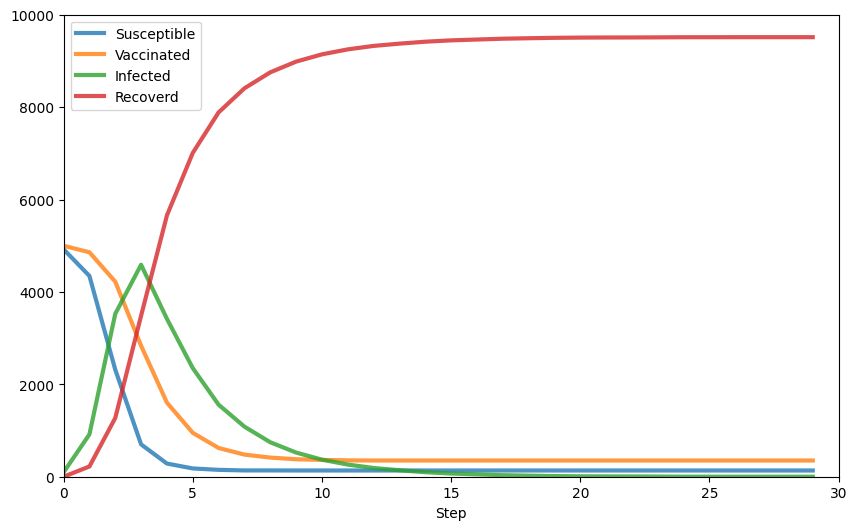

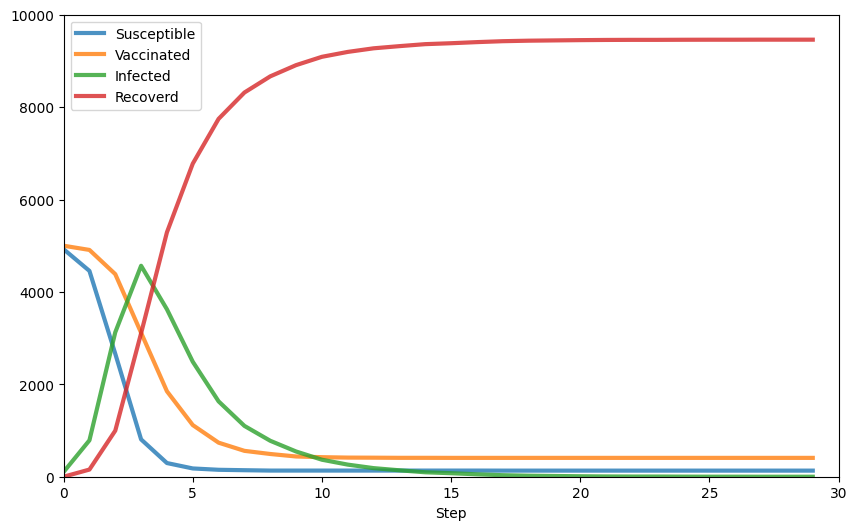

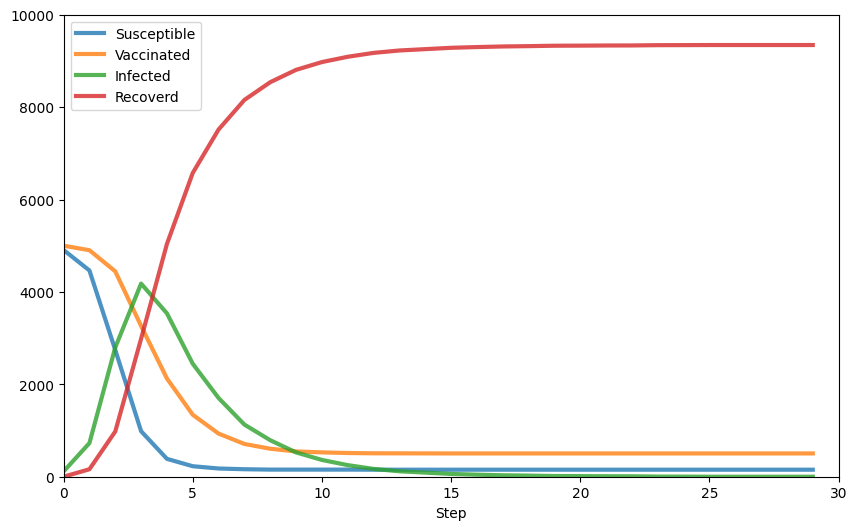

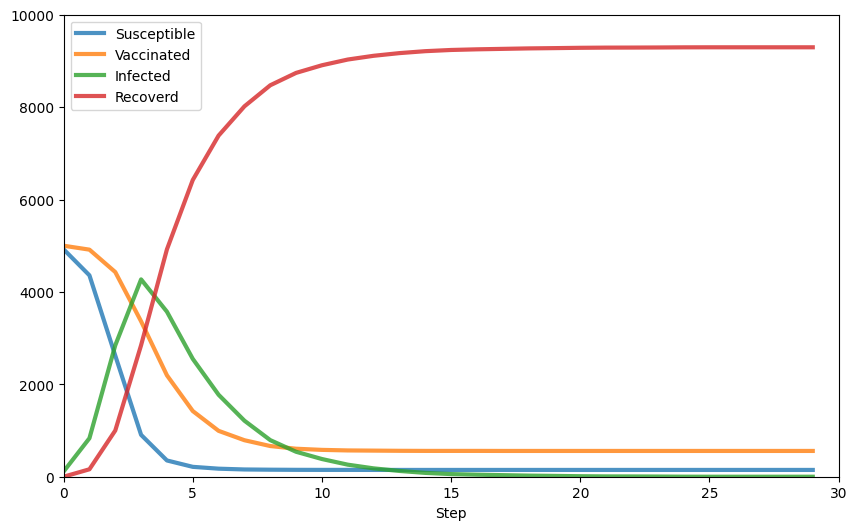

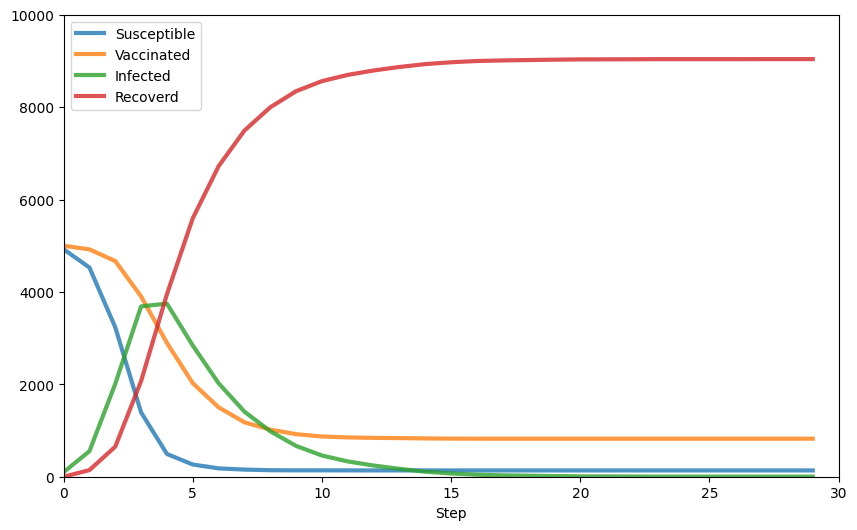

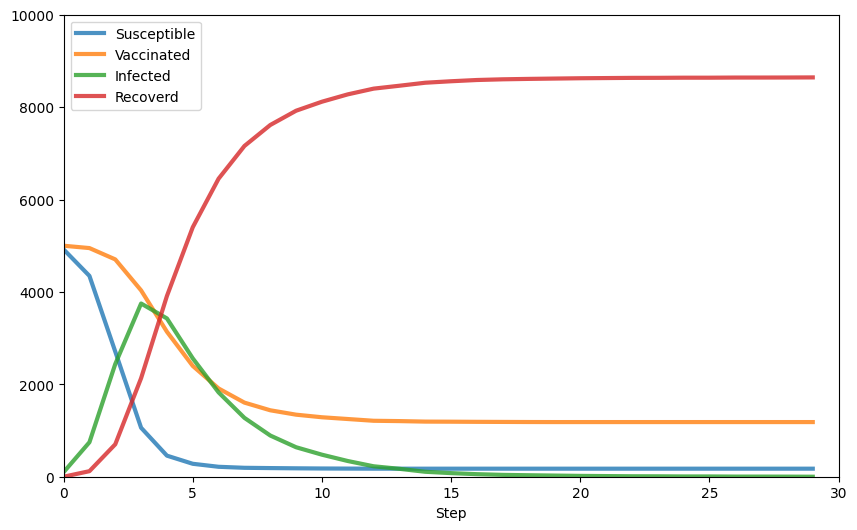

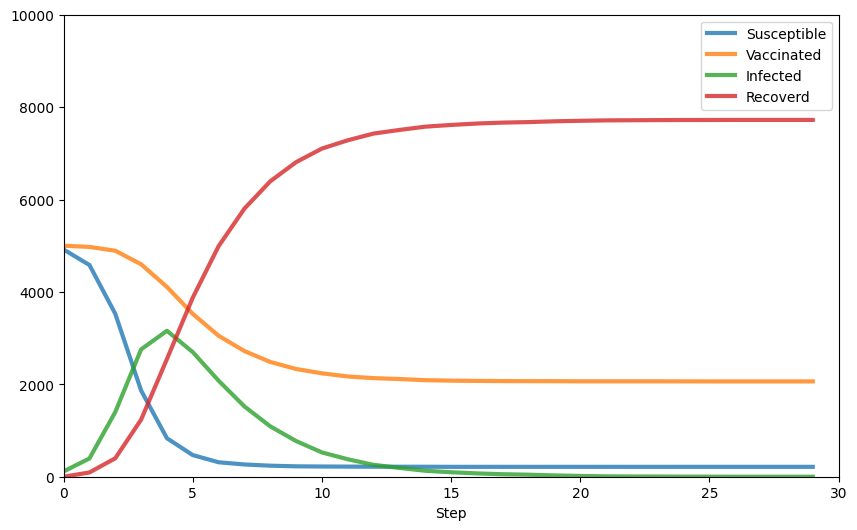

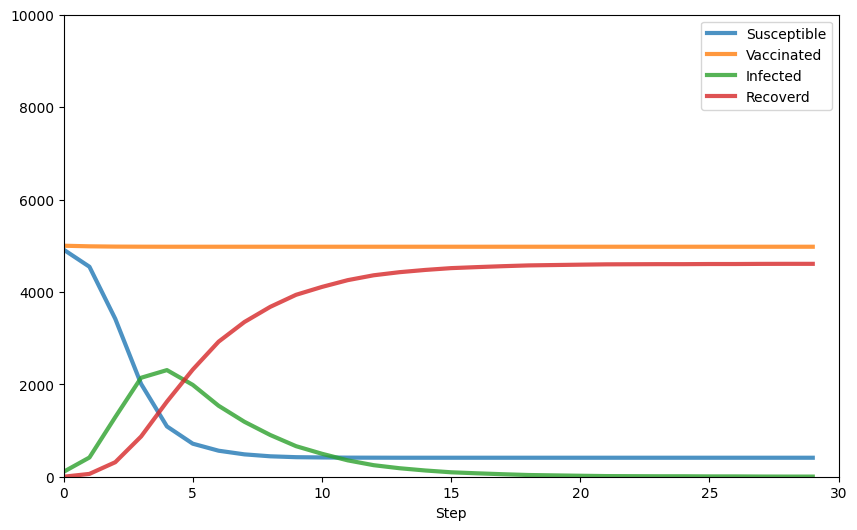

In [28]:
arr = np.arange(0,1.1,0.1)
for i in arr:
    population=10000
    steps = 30
    
    st=time.time()
    model = SIRVModel(N=population, num_vaccination=population*0.5, effectiveness = i)
    for i in range(steps):
        model.step()
    agent_state = model.datacollector.get_agent_vars_dataframe()



    X = prep(model)
    f,ax= plt.subplots(1,1,figsize=(10,6))
    X.plot(ax=ax,lw=3,alpha=0.8,xlim=[0,steps],ylim=[0,population])
    plt.plot()
    plt.show()
    